# Memory-based collaborative filtering

<b>Memory-based collaborative filtering</b> is recommendation strategy which uses the information about user rating historical data. Based on that information it calculates similarity between users or items and recommend the most similar. 

I will focus on two typical approaches:

1. <b>User-based</b> - measures the similarity between target users and other users.


2. <b>Item-based</b> - measures the similarity between the items that target users rate and other items.


In this project the recommendation engine will the Surprise library in Python.


## Import libraries

In [164]:
import pandas as pd
import random
from surprise import Reader, Dataset
from surprise.model_selection import GridSearchCV
from surprise.prediction_algorithms import KNNBasic,KNNBaseline,KNNWithZScore,KNNWithMeans
from surprise import accuracy
from eda import show_df_info, show_duplicates, choose_values, grouping, check_ratings
from recommend import get_top_n, get_names
import matplotlib.pyplot as plt
from model_graf import plot_diff

## Data

1. <b>Ratings</b> - contain information how users rated specific books.

    Columns:
    * user_id
    * book_id
    * rating


2. <b>Books</b> - contain some information about books. In this notebook only few columns will be used.

    Columns:
    * book_id
    * title
    * authors

In [2]:
ratings = pd.read_csv(filepath_or_buffer='./goodbooks-10k-1.0/ratings.csv')
books = pd.read_csv(filepath_or_buffer='./goodbooks-10k-1.0/books.csv', usecols=['book_id','title','authors'])

## Exploatory Data Analysis

Let's check how data looks like, if there are any NaN values or duplicated rows.

In [3]:
show_df_info(ratings)

Header : 


,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


Number of rows : 5976479
Number of NaN values in each column : 


user_id    0
book_id    0
rating     0
dtype: int64

In [4]:
show_duplicates(ratings[['user_id','book_id']])

Number of duplicated rows : 


0

In [5]:
show_df_info(books)

Header : 


,book_id,authors,title
0,1,Suzanne Collins,"The Hunger Games (The Hunger Games, #1)"
1,2,"J.K. Rowling, Mary GrandPré",Harry Potter and the Sorcerer's Stone (Harry P...
2,3,Stephenie Meyer,"Twilight (Twilight, #1)"
3,4,Harper Lee,To Kill a Mockingbird
4,5,F. Scott Fitzgerald,The Great Gatsby


Number of rows : 10000
Number of NaN values in each column : 


book_id    0
authors    0
title      0
dtype: int64

Information about well-known book 'Harry Potter and the Sorcerer's Stone' is shown above. It is obvious that the author of this books is J.K. Rowling. Mary GrandPré is an illustrator. Only information about the author is needed in order to identify the book. In this case I will leave only one person name in the author column. Even if a book has more than one author it still will be easy to find if we knew one author + title.

In [6]:
books.authors = books.authors.str.partition(',')[0]

In [7]:
show_duplicates(books)

Number of duplicated rows : 


0

There is almost a 6 million ratings - it would be hard to process such amount of data. I have to reduce the number of observations. I will randomly choose around 5% of users. The new ratings dataframe will contain only rates given by these users.

In [8]:
random.seed(5)

In [9]:
n = 0.05
ratings = choose_values(n, ratings, 'user_id')

In [10]:
print(f'Current number of rows in ratings dataframe is {len(ratings)}.')

Current number of rows in ratings dataframe is 299308.


Let's see the distribution of number of ratings per book:

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


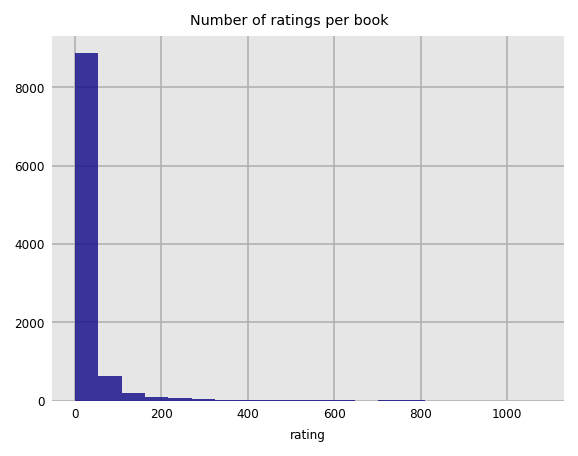

Statistics for dataframe grouped by book_id:
count    9987.000000
mean       29.969761
std        63.095292
min         1.000000
25%         8.000000
50%        13.000000
75%        26.000000
max      1079.000000
Name: rating, dtype: float64


In [11]:
check_ratings(ratings, 'book_id')

Let's see the distribution of number of books ratings per user:

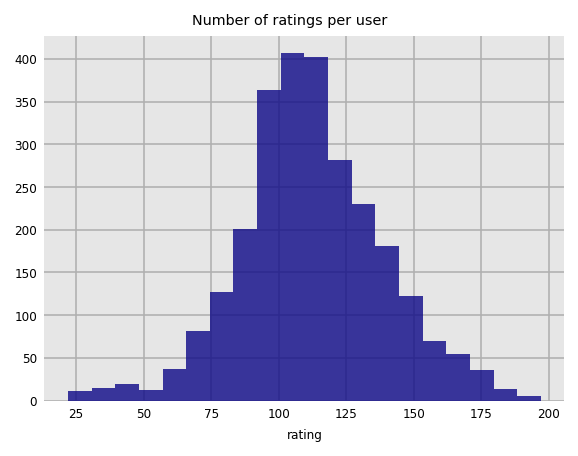

Statistics for dataframe grouped by user_id:
count    2671.000000
mean      112.058405
std        26.419597
min        22.000000
25%        96.000000
50%       111.000000
75%       128.000000
max       197.000000
Name: rating, dtype: float64


In [12]:
check_ratings(ratings, 'user_id')

Statistics for ratings :

In [13]:
ratings.rating.describe()

count    299308.000000
mean          3.906752
std           0.988437
min           1.000000
25%           3.000000
50%           4.000000
75%           5.000000
max           5.000000
Name: rating, dtype: float64

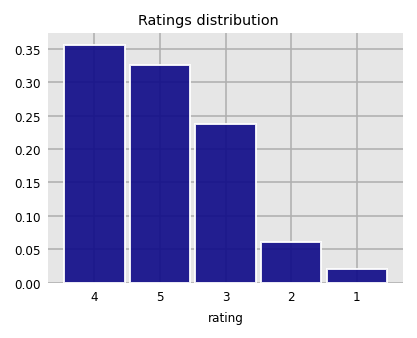

In [14]:
dexplot.count(val='rating', data=ratings, normalize= True, title='Ratings distribution', cmap='plasma')

## Prediction models

In [15]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings, reader)
raw_ratings = data.raw_ratings
train = data

In [16]:
random.shuffle(raw_ratings)

Divide data into train and test - 20% of data will be in test 

In [17]:
train_size = int(.8 * len(raw_ratings)) 
train_raw_ratings = raw_ratings[:train_size]                             
test_raw_ratings = raw_ratings[train_size:]                                 
train.raw_ratings = train_raw_ratings

In [18]:
data.raw_ratings = train_raw_ratings

User-based collaborative filtering - for evaulation I will use RMSE.

In [24]:
#model_dict = {'KNNBasic': KNNBasic,'KNNBaseline': KNNBaseline,
#              'KNNWithZScore': KNNWithZScore, 'KNNWithMeans' :KNNWithMeans}
#param_grid = {'k': [20, 30, 40], 
#              'min_k' : [1, 2, 3],
#              'sim_options': {'user_based': [True],
#                             'name' : ['cosine', pearson']}
#             }
param_grid = {'k': [20, 30, 40],
             'min_k' : [1, 2, 3]}
results = []

In [32]:
for name, model in model_dict.items():
    grid = GridSearchCV(model,param_grid, cv = 5, n_jobs=-1)
    grid.fit(data)
    print(f' Best params for model {str(model)} are {grid.best_params}')
    results.append((name, grid.best_estimator['rmse'], grid.best_estimator['mae']))

 Best params for model <class 'surprise.prediction_algorithms.knns.KNNBasic'> are {'rmse': {'k': 30, 'min_k': 3}, 'mae': {'k': 20, 'min_k': 3}}
 Best params for model <class 'surprise.prediction_algorithms.knns.KNNBaseline'> are {'rmse': {'k': 40, 'min_k': 3}, 'mae': {'k': 40, 'min_k': 3}}


In [ ]:
#print(name)


Comparison of algorithms.

In [33]:
rmse = []
mae = []
for name, model,_ in results:
    print(name)                                                     
                                                                           
    # now test on the trainset                                                 
    trainset = data.build_full_trainset()
    model.fit(trainset)                                          

    # Compute biased accuracy on A
    predictions = model.test(trainset.build_testset())
    print('Biased accuracy on A,', end='   ')
    accuracy.rmse(predictions)

    # Compute unbiased accuracy on B
    testset = data.construct_testset(test_raw_ratings)  # testset is now the set B
    predictions = model.test(testset)
    print('Unbiased accuracy on B,', end=' ')
    accuracy.rmse(predictions)                                                                                        
    rmse_score = accuracy.rmse(predictions)
    mae_score = accuracy.mae(predictions)
    print("RMSE: {}".format(rmse_score))
    print("MAE: {}".format(mae_score))
    rmse.append(rmse_score)
    mae.append(mae_score)

KNNBasic
Computing the msd similarity matrix...
Done computing similarity matrix.
Biased accuracy on A,   RMSE: 0.5933
Unbiased accuracy on B, RMSE: 0.9138
RMSE: 0.9138
MAE:  0.7229
RMSE: 0.9138192588149974
MAE: 0.7228582616208248
KNNBaseline
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Biased accuracy on A,   RMSE: 0.6013
Unbiased accuracy on B, RMSE: 0.8576
RMSE: 0.8576
MAE:  0.6691
RMSE: 0.8575599033246115
MAE: 0.6691142192772588
KNNBasic
Computing the msd similarity matrix...
Done computing similarity matrix.
Biased accuracy on A,   RMSE: 0.5933
Unbiased accuracy on B, RMSE: 0.9138
RMSE: 0.9138
MAE:  0.7229
RMSE: 0.9138192588149974
MAE: 0.7228582616208248
KNNBaseline
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Biased accuracy on A,   RMSE: 0.6013
Unbiased accuracy on B, RMSE: 0.8576
RMSE: 0.8576
MAE:  0.6691
RMSE: 0.8575599033246115
MAE: 0.6691142192772588


In [167]:
d = {'RMSE': rmse, 
     'MAE': mae
    }
df = pd.DataFrame(data=d)
#df.insert(loc=0, column='Method', value=['KNNBasic','KNNBaseline',
#              'KNNWithZScore','KNNWithMeans'])
df.insert(loc=0, column='Method', value=['KNNBasic','KNNBaseline'])
color = (df.RMSE == df.RMSE.min()).map({True: 'background-color: yellow', False: 'background_color: white'})
df.style.apply(lambda s: color)

,Method,RMSE,MAE
0,KNNBasic,0.913819,0.722858
1,KNNBaseline,0.857560,0.669114


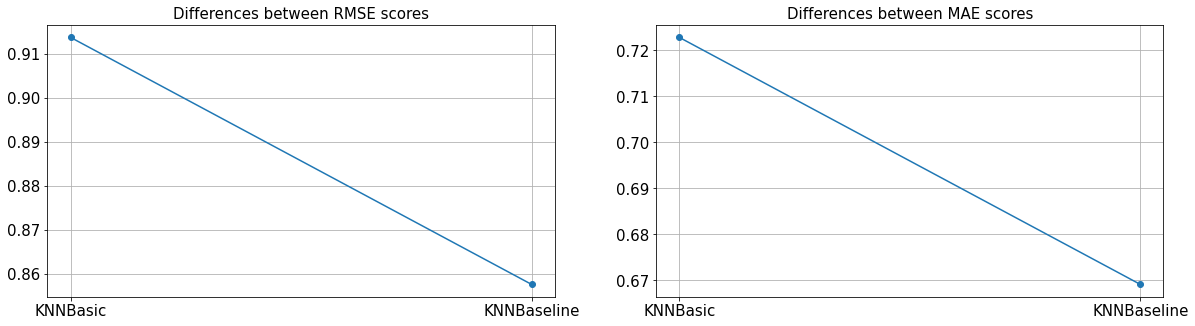

In [169]:
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plot_diff(df, 'Method', 'RMSE')
plt.subplot(1, 2, 2)
plot_diff(df, 'Method', 'MAE')
plt.show()

## Recommendations

Now we can finally recommend books for the users. 
Let's use the algorithm which has the lowest RMSE on test set.

In [23]:
model_idx = df['rmse'].idxmin()
model = results[model_idx][1]
model

Let's recommend 10 books for user 3173.

In [46]:
top_n = get_top_n(3173, ratings, model,n=10)
get_names(top_n, books)

,book_id,prediction,pred_rating,authors,title
0,7368,4.977298,5,C.S. Pacat,"Captive Prince: Volume Two (Captive Prince, #2)"
1,8634,4.903610,5,Ibraheem Abbas,حوجن [Ḥawjan]
2,3241,4.845167,5,Leigh Bardugo,"Crooked Kingdom (Six of Crows, #2)"
3,1788,4.813306,5,Bill Watterson,The Calvin and Hobbes Tenth Anniversary Book
4,2149,4.806308,5,George R.R. Martin,A Song of Ice and Fire (A Song of Ice and Fire...
5,862,4.803856,5,Brandon Sanderson,"Words of Radiance (The Stormlight Archive, #2)"
6,2767,4.800888,5,Brian K. Vaughan,"Saga, Vol. 3 (Saga, #3)"
7,5312,4.786217,5,Mike Mignola,"Hellboy, Vol. 3: The Chained Coffin and Others..."
8,4868,4.781562,5,James E. Talmage,Jesus the Christ
9,7910,4.776414,5,V.S. Ramachandran,Phantoms in the Brain: Probing the Mysteries o...


In [45]:
ratings.user_id

0              1
44             8
45             8
46             8
47             8
           ...  
5976347    41259
5976456     3173
5976458    53358
5976459    53358
5976471    50229
Name: user_id, Length: 895064, dtype: int64

Let's look at the list of books which user 3173 gave rate 5 and compare it to recommendation list

In [49]:
get_names(ratings[(ratings.rating == 5) & (ratings.user_id == 3173)], books)

,user_id,book_id,rating,authors,title
0,3173,250,5,R.J. Palacio,Wonder
1,3173,70,5,Orson Scott Card,"Ender's Game (Ender's Saga, #1)"
2,3173,4112,5,Donald J. Sobol,"Encyclopedia Brown, Boy Detective (Encyclopedi..."
3,3173,6,5,John Green,The Fault in Our Stars
4,3173,3630,5,Ron Rash,Serena
5,3173,7713,5,Hiroshi Sakurazaka,All You Need Is Kill
6,3173,164,5,Rainbow Rowell,Eleanor & Park
7,3173,591,5,Sherman Alexie,The Absolutely True Diary of a Part-Time Indian
8,3173,610,5,Daniel James Brown,The Boys in the Boat: Nine Americans and Their...
9,3173,285,5,Graeme Simsion,"The Rosie Project (Don Tillman, #1)"


#  References
1. https://towardsdatascience.com/how-does-collaborative-filtering-work-da56ea94e331
2. http://surprise.readthedocs.io/en/stable/getting_started.html